In [93]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from intra import IntrA
from models.pointnet import PointNetCls
from models.pointnet2 import PointNet2
from utils import train_model, eval_model

dev = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
dataset = IntrA("~/Documents/Datasets/IntrA", dataset="generated", npoints=1024, exclude_seg=True)

tacc = 0
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for fold, (train_ids, test_ids) in enumerate(kf.split(dataset), start=1):
    model = PointNetCls(k=2, feature_transform=False)
    # if opt.model != "":
    #     model.load_state_dict(torch.load(opt.model))

    train_srs, test_srs = SubsetRandomSampler(train_ids), SubsetRandomSampler(test_ids)
    train_dl = DataLoader(dataset, batch_size=8, sampler=train_srs)
    test_dl = DataLoader(dataset, batch_size=8, sampler=test_srs)
    train_model(model, train_dl, test_dl, model_name=f"PointNet_Fold{fold}")
    facc = eval_model(model, test_dl)
    tacc += facc
    print(f"Fold: {fold}. Fold acc: {facc}. Overall acc: {tacc/fold}.")

KeyboardInterrupt: 

In [113]:
dataset = IntrA("~/Documents/Datasets/IntrA", dataset="generated", npoints=1024, exclude_seg=True)
trn, tst = torch.utils.data.random_split(dataset, [0.8, 0.2], torch.Generator().manual_seed(42))

model = PointNetCls(k=2, feature_transform=False)
# model = PointNet2(2, normal_channel=False)

train_dl = DataLoader(trn, batch_size=8)
test_dl = DataLoader(tst, batch_size=8)
train_model(model, train_dl, test_dl, epochs=6, checkpoint_epoch=2, model_name="PointNet")

tensor([0, 0, 0, 0, 1, 0, 0, 0], device='mps:0')


ZeroDivisionError: float division by zero

In [89]:
loaded_model = PointNetCls(k=2, feature_transform=False)
loaded_model.to(dev)
snapshot = torch.load("./snapshots/PointNet_2.ckpt", map_location=torch.device(dev))
loaded_model.load_state_dict(snapshot['state_dict'])
acc = eval_model(loaded_model, test_dl, verbose=True)
print(acc)

100%|██████████| 48/48 [00:02<00:00, 17.71it/s]

{0: 255, 1: 23}
Class Accuracies:
vessel: 255/345=0.7391304347826086
aneurysm: 23/36=0.6388888888888888
0.7296587926509186


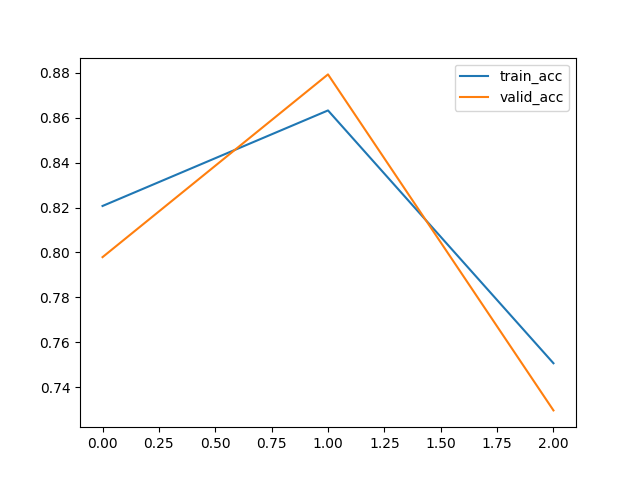

In [108]:
fig, ax = plt.subplots()
ax.plot(snapshot["history"]["train_acc"], label="train_acc")
ax.plot(snapshot["history"]["valid_acc"], label="valid_acc")
ax.legend()
plt.show()